# Quantum-classical Mapping

We want to simulate the dynamics

$W\left(s^{\prime} \mid s\right)=W(s \mid s) \delta_{s^{\prime}, s}+\sum_{K=1,2,\dots k} \sum_{a_k} g_{a_k}(s) \delta_{s^{\prime}, F_{a_k}[s]}$

The dirac deltas are there only to tell you which of the states is actually selected, all the calculation is in the flip-probabilities $g_a = [{g_i, g_{ij}}]$. The indices refer to which spin will get flipped. Your data would have the form of $(s_0,s_1, \dots s_t)$ with $s_i$  being states of the system. The $a$ represents a n-spin flip.  $g_i$ is the probability of the flip occurring.

This expression tells us that the transition probability is the sum of all probabilities of all the ways to get into state $s'$ using up to $a$-spin flips. We can use it to calculate the transition rates from a time series. w is an extra parameter that encodes the time scales of the transitions. Not related to coupling between spins.

For fully connected systems we have the flipping parameters:

$g_i(s)=\exp \left[-w_{i i}-s_i\left(h_i+\sum_{i \neq j} J_{i j} s_j\right)\right]$

$g_{ij}(s) = \exp \left(-w_{ij}+J_{ij} s_is_j - s_i \left[\sum_{k} J_{ik} s_k + h_i \right] - s_j \left[ \sum_{k'} J_{jk'} s_{k'} + h_j \right] \right)$

[No beta??]

Formalism -1/1 -> 1/0 for binary representation

#### Do this first for 2 qubits, then upgrade
2- From time series, learn the weights in W [weights that generated transition matrix] and W directly

3- From W generate eta (ensuring DB; so symmetrize the thing)

5- inverse mapping from rho to W and interpret wyy, wxx terms.wxz [Combine QBM and dynamics simulation code]

In [364]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import itertools
from scipy.optimize import minimize

In [365]:
###  SIMULATION FUNCTIONS
#----------------------------------------------------------------------
def g_single(i, s, w, h, J):
    """Probability associated with a single spin flip"""
    sum_term = h[i] + sum(J[i, j] * s[j] for j in range(len(s)) if i != j)
    return np.exp(-w[i, i] - s[i] * sum_term)

def g_double(i, j, s, w, h, J):
    """Probability associated with a double spin flip"""
    sum_term_i = h[i] + sum(J[i, k] * s[k] for k in range(len(s)) if k != i)
    sum_term_j = h[j] + sum(J[j, k] * s[k] for k in range(len(s)) if k != j)
    return np.exp(-w[i, j] + J[i, j] * s[i] * s[j] - s[i] * sum_term_i - s[j] * sum_term_j)


def flip_parallel(s, w, h, J):
    """Flipping algorithm using parallel dynamics using double-spin flips"""
    N = len(s)         # Number of spins in the lattice
    s_prime = s.copy()

    #calculate all possible flipping probabilities from state s
    flip_probs = [g_single(i, s, w, h, J) for i in range(N)]       # single flip probabilities
    # append double flip probabilities
    flip_probs += [g_double(i, j, s, w, h, J) for i in range(N) for j in range(i+1, N)]  #double flip probabilities
    
    # add probability for no flip ????
    no_flip_prob = 1              # this is not correct but don't know what it should be
    flip_probs.append(no_flip_prob)

    # normalize the probabilities
    flip_probs /= np.sum(flip_probs)
    
    # randomly choose a spin flip according to its probability of occurring
    idx = np.random.choice(len(flip_probs), p=flip_probs)

    num_single_flips = N
    num_double_flips = math.comb(N, 2)  #binomial coefficient N choose 2

    # If the chosen index corresponds to a single or double flip, perform the flip
    if idx < num_single_flips:  # single flip
        s_prime[idx] *= -1
    elif idx < num_single_flips + num_double_flips:  # double flip
        idx -= num_single_flips
        i, j = divmod(idx, N-1) #calculate the indices i (quotient) and j (remainder) for the double flip
        if j >= i:              #correctly index the upper triangular part of the matrix
            j += 1
        s_prime[i] *= -1
        s_prime[j] *= -1
    # If the chosen index corresponds to no flip, do nothing
    else:  
        pass  # No flip

    return s_prime


def simulate_dynamics(w, J, h, steps, n_spins):
    s = np.array([np.random.choice(np.array([-1, 1])) for _ in range(n_spins)], dtype=np.int64) #initial config
    trajectory = np.empty((steps, n_spins), dtype=np.int64)
 
    for t in range(steps):
        s = flip_parallel(s,w,h,J)
        trajectory[t] = s 
        
    return trajectory


In [366]:
def plot_combined_dynamics(trajectory, n_spins):
    fig, (ax1,ax2)= plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot for the system's evolution through states
    states = [''.join(str(1 - (spin + 1) // 2) for spin in traj) for traj in trajectory]  # convert spins to binary
    unique_states = sorted(set(states))
    state_indices = [unique_states.index(state) for state in states]
    
    ax1.plot(range(len(state_indices)), state_indices)
    ax1.set_yticks(range(len(unique_states)))
    ax1.set_yticklabels(unique_states)
    ax1.set_title("System's evolution through states")
    ax1.set_xlabel('Time step')
    ax1.set_ylabel('State')

    # Plot for the spins' evolution
    offset_labels = []
    y_ticks = []
    for i in range(n_spins):
        spin_trajectory = trajectory[:, i] + i * 3
        ax2.plot(range(len(spin_trajectory)), spin_trajectory, label=f'Spin {i+1}')
        offset_labels += ['0', '1']
        y_ticks += [(i*3 - 1), (i*3 +1)]
        
    ax2.set_title("Spins' evolution")
    ax2.set_xlabel('Time step')
    ax2.set_ylabel('Spin value (with offset)')
    ax2.set_yticks(y_ticks)
    ax2.set_yticklabels(offset_labels)
    ax2.legend(loc='best')
    ax2.plot()
    
    plt.tight_layout()
    plt.show()


## Example simulation

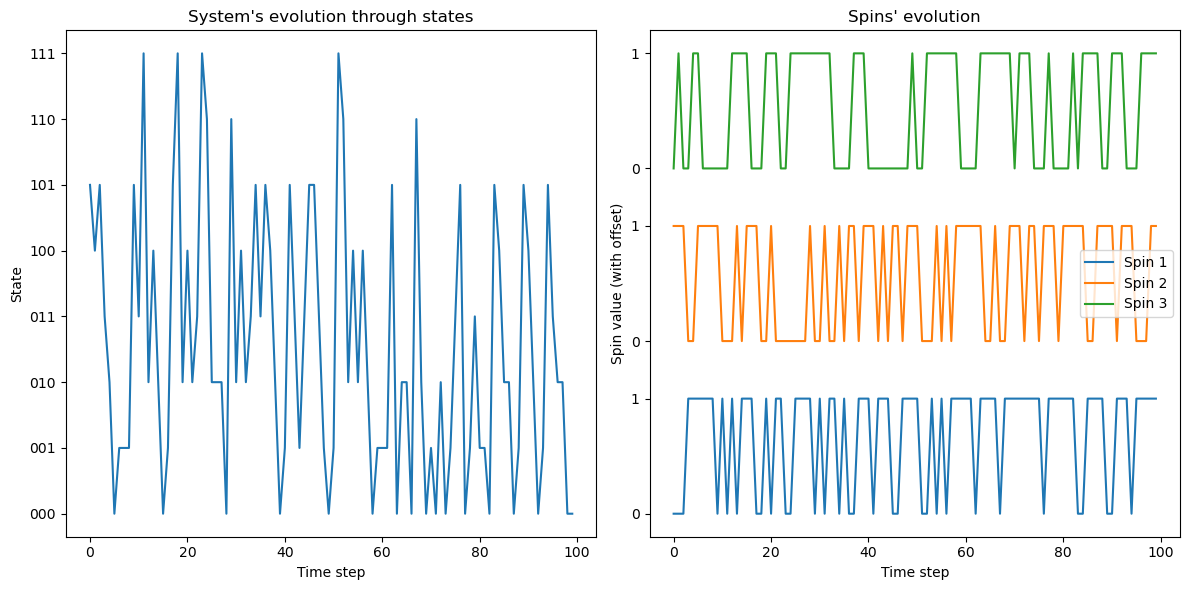

In [367]:
# Initialize parameters
n_spins = 3
steps = 100
w = np.random.normal(size=(n_spins, n_spins))
h = np.random.normal(size=n_spins)
J = np.random.normal(size=(n_spins, n_spins))

trajectory = simulate_dynamics(w, J, h, steps, n_spins)
plot_combined_dynamics(trajectory, n_spins)



In [382]:
###TRANSITION MATRIX FUNCTIONS
#----------------------------
def transition_probabilities(s, w, h, J):
    """Calculates the row in the transition matrix corresponding to spin s"""
    N = len(s)
    transition_probs = np.zeros(2**N)
    
    for state_idx in range(2**N):
        s_prime = [(state_idx >> i) & 1 for i in reversed(range(N))] # binary representation with reversed order
        s_prime = (1 - np.array(s_prime)) * 2 - 1 # conversion to spin representation
        
        flipped_spins = np.where(s != s_prime)[0] # returns array with the indices of the differing spins 
        
        #calculate and store the transition probability associated with s'
        if len(flipped_spins) == 0:   #no spin flips
            transition_probs[state_idx] = 1.0
        elif len(flipped_spins) == 1: # single spin flip
            i = flipped_spins[0]
            transition_probs[state_idx] = g_single(i, s, w, h, J)
        elif len(flipped_spins) == 2: # double spin flip
            i, j = flipped_spins
            transition_probs[state_idx] = g_double(i, j, s, w, h, J)
        else:
            transition_probs[state_idx] = 0.0
            
    transition_probs /= np.sum(transition_probs)
    
    return transition_probs

def transition_matrix(w, h, J):
    """Calculates the entire transition matrix"""
    n = len(w)
    states = [np.array([(i >> j) & 1 for j in reversed(range(n))]) for i in range(2**n)] # binary representation with reversed order
    states = [(1 - state) * 2 - 1 for state in states] # conversion to spin representation
    
    transition_matrix = np.zeros((2**n, 2**n))
    
    for i, s in enumerate(states):
        probs = transition_probabilities(s, w, h, J)
        transition_matrix[i, :] = probs
    
    return transition_matrix


## Code for simulating and infering the classical dynamics

In [185]:
def likelihood(params, data):
    # This function calculates the likelihood of the data given the parameters
    w = params[:len(s)]
    h = params[len(s):2*len(s)]
    J = params[2*len(s):].reshape(len(s), len(s))

    likelihood = 0
    for i in range(len(data) - 1):
        transition_prob = transition_matrix(w, h, J, data[i])[data[i+1]]
        likelihood += np.log(transition_prob)
    
    return -likelihood # we return the negative likelihood because we want to minimize this function

def infer_parameters(data):
    # We will use the scipy minimize function to find the parameters that maximize the likelihood
    # We need to provide an initial guess for the parameters
    initial_guess = np.random.normal(size=3*len(data[0])**2) # assuming w, h, J are of the same size
    result = minimize(likelihood, initial_guess, args=(data,), method='BFGS')
    if result.success:
        inferred_params = result.x
        return inferred_params
    else:
        raise ValueError(result.message)
    
    
def log_likelihood(params, trajectory, beta):
    n_spins = trajectory.shape[1]
    
    J = np.reshape(params[:n_spins**2], (n_spins, n_spins))
    h = params[n_spins**2:]
    
    # Define all possible states
    all_states = np.array(list(itertools.product([-1, 1], repeat=n_spins)))
    
    # Calculate the partition function Z
    Z = np.sum([np.exp(-beta * energy(s, J, h)) for s in all_states])
    
    # Compute the Boltzmann probabilities for each state in the trajectory
    energies = np.array([energy(s, J, h) for s in trajectory])
    boltzmann_probabilities = np.exp(-beta * energies) / Z
    
    # Calculate the log-likelihood
    log_likelihood = np.sum(np.log(boltzmann_probabilities))
    return -log_likelihood

###  CONVERGENCE FUNCTIONS
#----------------------------------------------------------------------
def boltzmann_distribution(J, h, beta):
    n_spins = len(h)
    all_states = np.array([[1 if digit=='0' else -1 for digit in f"{i:0{n_spins}b}"] for i in range(2**n_spins)])
    energies = np.array([energy(state, J, h) for state in all_states])
    probabilities = np.exp(-beta * energies)
    Z = np.sum(probabilities)
    return probabilities / Z


def check_convergence_to_boltzmann(J, h, beta, trajectory, tolerance=0.01):
    n_spins = len(h)
    boltzmann_probs = boltzmann_distribution(J, h, beta)

    # Count the occurrences of each unique spin state in the trajectory
    state_counts = {}
    for state in trajectory:
        state_tuple = tuple(state)
        if state_tuple in state_counts:
            state_counts[state_tuple] += 1
        else:
            state_counts[state_tuple] = 1

    # Calculate the empirical probabilities from the trajectory
    empirical_probs = np.zeros(2**n_spins)
    for idx, state in enumerate(np.array([[1 if digit=='0' else -1 for digit in f"{i:0{n_spins}b}"] for i in range(2**n_spins)])):
        state_tuple = tuple(state)
        if state_tuple in state_counts:
            empirical_probs[idx] = state_counts[state_tuple] / len(trajectory)

    # Check if the difference between the Boltzmann probabilities and the empirical probabilities is within the tolerance
    difference = np.abs(boltzmann_probs - empirical_probs)
    converged = np.all(difference <= tolerance)

    return converged, difference

###  INFERENCE FUNCTIONS
#----------------------------------------------------------------------
def infer_empirical_transition_matrix(trajectory):
    # Define all possible states
    n_spins = trajectory.shape[1]
    all_states = np.array(list(itertools.product([-1, 1], repeat=n_spins)))

    # Convert states in the trajectory to indices
    state_indices = np.array([np.where((all_states == state).all(axis=1))[0][0] for state in trajectory])

    # Initialize transition matrix
    transition_matrix = np.zeros((2**n_spins, 2**n_spins))

    # Count the transitions
    for i in range(len(state_indices) - 1):
        transition_matrix[state_indices[i], state_indices[i + 1]] += 1

    # Normalize the transition matrix
    transition_matrix = transition_matrix / np.sum(transition_matrix, axis=1, keepdims=True)

    return transition_matrix

def infer_parameters_scipy(trajectory, beta, initial_guess=None):
    """Infer the parameters using some Scipy minimzation of the likelihood. Implement QBM later"""
    n_spins = trajectory.shape[1]
    n_params = n_spins**2 + n_spins
    
    if initial_guess is None:
        initial_guess = np.random.randn(n_params)
    
    result = minimize(log_likelihood, initial_guess, args=(trajectory, beta), method='L-BFGS-B')
    return result.x

def infer_model_transition_matrix():
    """ From the inferred parameters, calculate the associated transition matrix"""
    return 

In [186]:
###  PLOTTING FUNCTIONS
#----------------------------------------------------------------------
def plot_convergence_to_boltzmann(J, h, beta, trajectory):
    n_spins = len(h)
    boltzmann_probs = boltzmann_distribution(J, h, beta).flatten()

    # Count the occurrences of each unique spin state in the trajectory
    state_counts = {}
    for state in trajectory:
        state_tuple = tuple(state)
        if state_tuple in state_counts:
            state_counts[state_tuple] += 1
        else:
            state_counts[state_tuple] = 1

    # Calculate the empirical probabilities from the trajectory
    empirical_probs = np.zeros(2**n_spins)
    for idx, state in enumerate(np.array([[1 if digit=='0' else -1 for digit in f"{i:0{n_spins}b}"] for i in range(2**n_spins)])):
        state_tuple = tuple(state)
        if state_tuple in state_counts:
            empirical_probs[idx] = state_counts[state_tuple] / len(trajectory)


    # Plot the Boltzmann probabilities and the empirical probabilities
    state_labels = [system_state(state) for state in np.array([[1 if digit=='0' else -1 for digit in f"{i:0{n_spins}b}"] for i in range(2**n_spins)])]
    x = np.arange(len(state_labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(6, 3))
    rects1 = ax.bar(x - width / 2, boltzmann_probs, width, label='Boltzmann', color='SteelBlue', alpha=0.8)
    rects2 = ax.bar(x + width / 2, empirical_probs, width, label='Empirical', color='Coral', alpha=0.8)

    ax.set_ylabel('Probability')
    ax.set_xlabel('Spin states')
    ax.set_title('Boltzmann vs Empirical Probabilities')
    ax.set_xticks(x)
    ax.set_xticklabels(state_labels)
    ax.legend()

    plt.show()


## Results N = 1

In [388]:
n_spins =2
w = np.random.normal(size=(n_spins, n_spins))
h = np.random.normal(size=n_spins)

print(w.shape)
print(h.shape)

w = np.array([[1.2,1.1],
              [1.1,1.2]])

h = np.array([1.0, 0.5])

print(w.shape)
print(h.shape)

(2, 2)
(2,)
(2, 2)
(2,)


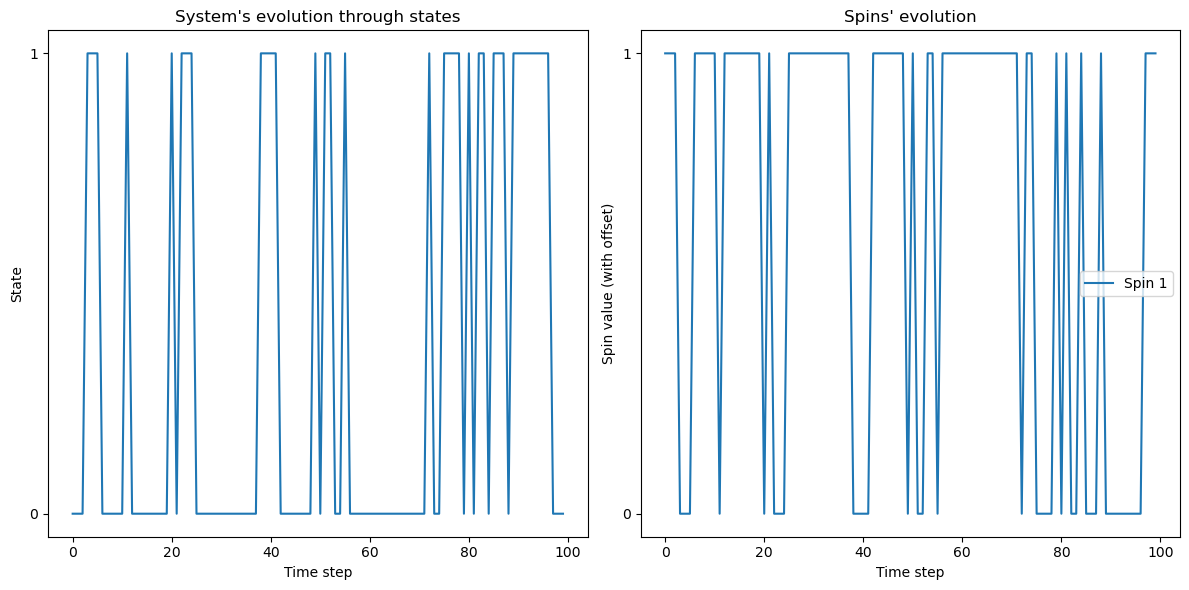

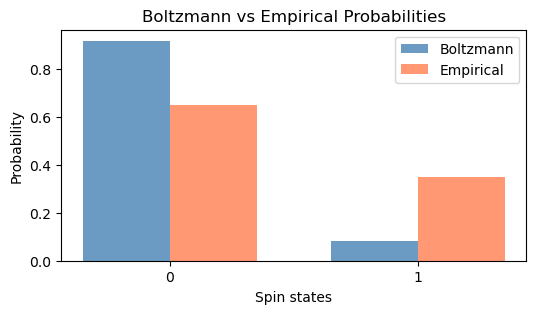

Converged: False
Difference: [0.2668273 0.2668273]
Inferred w: [0.34890995], Inferred h: [0.1031732]
Inferred J: [[0.6     0.4    ]
 [0.21875 0.78125]]
2.0


In [386]:
n_spins = 1
w = np.array([[1]])
J = np.array([[1]])
h = np.array([0.4])

beta = 3
steps = 100
tolerance = 0.1

trajectory = simulate_dynamics(w, J, h, steps, n_spins)
plot_combined_dynamics(trajectory, n_spins)
plot_convergence_to_boltzmann(J, h, beta, trajectory)

converged, difference = check_convergence_to_boltzmann(J, h, beta, trajectory, tolerance)

print(f"Converged: {converged}")
print(f"Difference: {difference}")

params = infer_parameters_scipy(trajectory, beta)
inferred_w = params[:n_spins**2]
inferred_h = params[n_spins**2:]
print(f"Inferred w: {inferred_w}, Inferred h: {inferred_h}")

W_empirical = infer_empirical_transition_matrix(trajectory)
print(f"Inferred J: {W_empirical}")
print(np.sum(W_empirical))

## Results N = 2

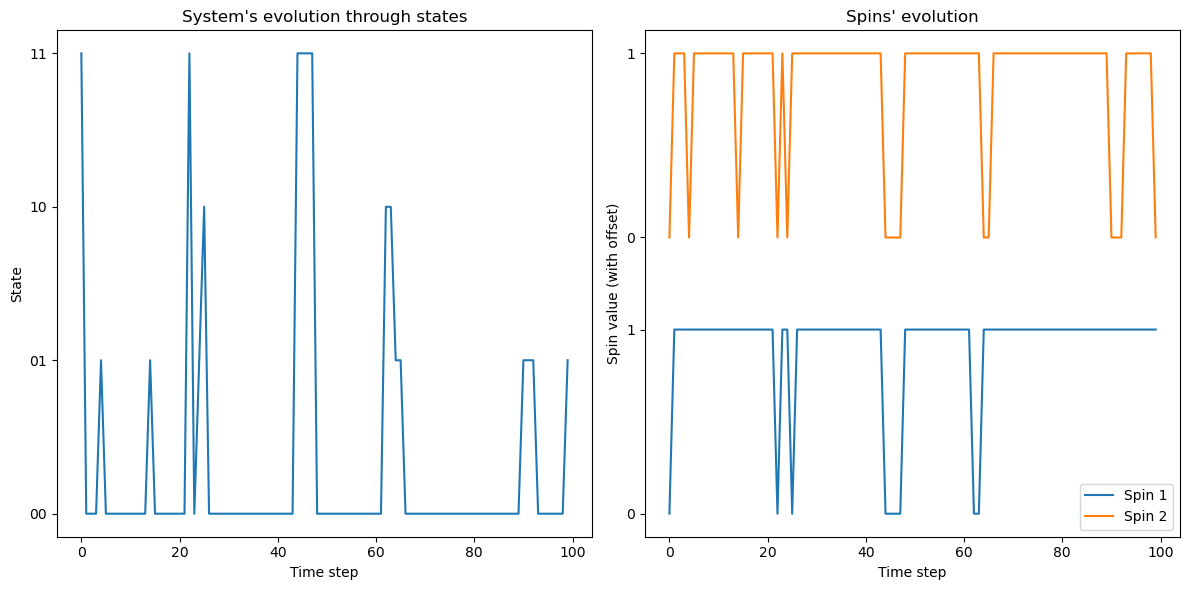

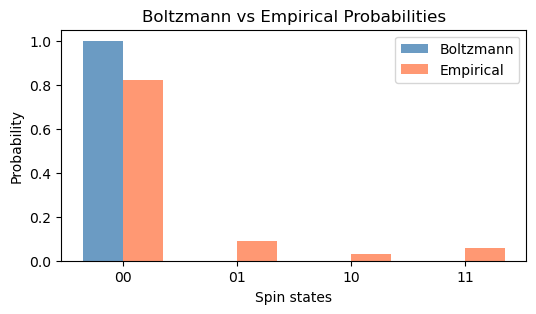

Converged: False
Difference: [0.17987628 0.08999969 0.02999998 0.05987661]
Inferred w: [ 0.33569094 -0.35288037  0.59476754  1.48076369] 
Inferred h: [0.30946464 0.12636199] 

Inferred W: 
 [[0.5        0.         0.         0.5       ]
 [0.         0.33333333 0.33333333 0.33333333]
 [0.         0.125      0.375      0.5       ]
 [0.02439024 0.01219512 0.06097561 0.90243902]] 

4.0


In [392]:
n_spins = 2
w = np.array([[1.2,1.1],
              [1.1,1.2]])
J = np.array([[1.,1.],
              [1.,1.]])
h = np.array([1.0, 0.5])
steps = 100
tolerance = 0.12

trajectory = simulate_dynamics(w, J, h, steps, n_spins)
plot_combined_dynamics(trajectory, n_spins)
plot_convergence_to_boltzmann(J, h, beta, trajectory)

converged, difference = check_convergence_to_boltzmann(J, h, beta, trajectory, tolerance)

print(f"Converged: {converged}")
print(f"Difference: {difference}")

params = infer_parameters_scipy(trajectory, beta)
inferred_w = params[:n_spins**2]
inferred_h = params[n_spins**2:]
print(f"Inferred w: {inferred_w} \nInferred h: {inferred_h} \n")

W_empirical = infer_empirical_transition_matrix(trajectory)
print(f"Inferred W: \n {W_empirical} \n")

## Code for the 2-qubit QBM

## DANGER ZONE: 2+ QUBITS

n_spins = 3
W = np.array([[0, 1.0, 0.5], [1.0, 0, 0.7], [0.5, 0.7, 0]])
h = np.array([1.0, -1.0, 0.5])
beta = 0.5
steps = 10000

trajectory = simulate_dynamics(W, h, beta, steps, n_spins)
plot_combined_dynamics(W, h, beta, steps, n_spins, flip_two_spins=True)
plot_convergence_to_boltzmann(W, h, beta, trajectory)

converged, difference = check_convergence_to_boltzmann(W, h, beta, trajectory, tolerance)

print(f"Converged: {converged}")
print(f"Difference: {difference}")

params = infer_parameters_scipy(trajectory, beta)
inferred_w = params[:n_spins**2]
inferred_h = params[n_spins**2:]
print(f"Inferred w: {inferred_w}, Inferred h: {inferred_h}")

print(f"Inferred W: {W_empirical}")
print(np.sum(W_empirical))


In [ ]:
###3Old functions

def energy(s, J, h):
    """
    Compute the energy of the system in a particular spin state.
    """
    s = s.astype(np.float64)                              # convert the spin configuratio to float64 for numba
    pairwise_energy = np.dot(s, np.dot(J, s))
    local_field_energy = h * s                            # simple multiplication for scalar-array operation
    return -pairwise_energy - np.sum(local_field_energy)  # sum over local field energy


def flip_metropolis(s, J, h, beta, flip_two_spins=False):
    """Flipping algorithm using sequential dynamics and metropolis hashting"""
    s_prime = np.copy(s)
    
    #select spins to be flipped
    if flip_two_spins and np.random.rand() < 0.5:
        flip_indices = np.random.permutation(len(s))[:2]     # selects two spin indices to be flipped
    else:
        flip_indices = np.array([np.random.randint(len(s))]) # selects a single spin index to be flipped
    
    # flip the spins and calculate energy difference
    s_prime[flip_indices] *= -1
    delta_E = energy(s_prime, J, h) - energy(s, J, h)
    
    # accept or reject new state based on metropolis update rule
    if delta_E < 0 or np.random.rand() < np.exp(-beta * delta_E):
        s = s_prime
    
    return s